In [1]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
sys.path.append('/eos/project/l/liu/Toolbox/')
from myToolbox import *
from scipy.signal import savgol_filter
import gzip
#from uncertainties import ufloat

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/h/harafiqu/SWAN_projects/PS
Your IP is 172.17.0.8
2018-10-04 15:49:49


In [2]:
#myFiles=glob.glob('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018*.mat')
myFiles=glob.glob('/eos/user/h/harafiqu/MD4224/2018.09.05_vertical/2018*.mat')
#print myFiles

In [3]:
def fromMatlabToDataFrame(listing, listOfVariableToAdd, verbose=False, matlabFullInfo=False):
    listOfVariableToAdd=list(set(listOfVariableToAdd))
    myDataFrame=pnd.DataFrame({})
    cycleStamp=[]
    cycleStampHuman=[]
    PLS_matlab=[]
    matlabObject=[]
    matlabFilePath=[]
    for j in listOfVariableToAdd:
        exec(j.replace('.','_')+'=[]')
    for i in listing:
        if verbose:
            print(i)
        data=myToolbox.japcMatlabImport(i);
        if matlabFullInfo:
            matlabObject.append(data)
        #to correct
        localCycleStamp=np.nanmax(data.headerCycleStamps);
        deltaLocal_UTC=datetime.datetime.fromtimestamp(localCycleStamp/1e9)-datetime.datetime.utcfromtimestamp(localCycleStamp/1e9)
        utcCycleStamp=localCycleStamp+deltaLocal_UTC.total_seconds()*1e9
        cycleStamp.append(utcCycleStamp)
        aux=myToolbox.unixtime2datetimeVectorize(np.nanmax(data.headerCycleStamps)/1e9)
        cycleStampHuman.append(aux.tolist())
        PLS_matlab.append(data.cycleName)
        matlabFilePath.append(os.path.abspath(i))
        for j in listOfVariableToAdd:
            if hasattr(data,j.split('.')[0]):
                exec(j.replace('.','_') + '.append(data.' + j + ')')
            else:
                exec(j.replace('.','_') + '.append(np.nan)')
    myDataFrame['cycleStamp']=pnd.Series(cycleStamp,cycleStampHuman)
    myDataFrame['matlabPLS']=pnd.Series(PLS_matlab,cycleStampHuman)
    myDataFrame['matlabFilePath']=pnd.Series(matlabFilePath,cycleStampHuman)
    if matlabFullInfo:
        myDataFrame['matlabFullInfo']=pnd.Series(matlabObject,cycleStampHuman)
    for j in listOfVariableToAdd:
        exec('myDataFrame[\'' + j + '\']=pnd.Series(' +j.replace('.','_')+ ',cycleStampHuman)')    #myDataFrame=pnd.DataFrame({j:aux,
    return myDataFrame

def intensity_df(ndf,start=85,end=1185):
    df=ndf.copy()
    def losses(a):
        try:
            b=(a[start]-a[end])/a[start]*100 
        except:
            b=np.nan
        return b
    def ratio(a):
        try:
            c=a[end]/a[start]
        except:
            c=np.nan
        return c
    df['losses']=df['PR_BCT_ST.Samples.value.samples'].apply(losses)
    df['ratio']=df['PR_BCT_ST.Samples.value.samples'].apply(ratio)
    return df

def read_data(year=2018,month=9,date=5,hour=10,minutes=0,span=5,user='CPS%MD1',WS='64.V'):
    t1=datetime.datetime(year,month,date,hour,minutes)
    t2=t1+datetime.timedelta(hours=span)
    CALS=['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS),  'PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS),  'PR.BWS.{}_ROT:ACQ_DELAY'.format(WS), 'PR.BCT.LT:SAMPLES']
    df=myToolbox.fromTimberToDataFrame(CALS,t1,t2,fundamental=user)
    return  df

def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def gaussian_5_parameters(x, c, m, A, mu, sig):
    """gaussian_5_parameter(x, c, m, A, mu, sig)"""
    return c+m*x+A/np.sqrt(2*np.pi)/sig*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def makeGaussianFit_5_parameters(X,Y,for_df=False,window=50):
    try:      
        #i = np.where( (X>min(X)+10) & (X<max(X)-10) )
        i = np.where( (X>-40) & (X<40) )
        #i = np.where( (Y>1.01*min(Y)) & (Y<0.99*max(Y)) )
        X = X[i]
        Y = Y[i]
        indx_max = np.argmax(Y)
        mu0 = X[indx_max]
        window = window
        x_tmp = X[indx_max-window:indx_max+window]
        y_tmp = Y[indx_max-window:indx_max+window]
        offs0 = min(y_tmp)
        ampl = max(y_tmp)-offs0
        x1 = x_tmp[np.searchsorted(y_tmp[:window], offs0+ampl/2)]
        x2 = x_tmp[np.searchsorted(-y_tmp[window:], -offs0+ampl/2)]
        FWHM = x2-x1
        sigma0 = np.abs(2*FWHM/2.355)
        ampl *= np.sqrt(2*np.pi)*sigma0
        slope = 0
        popt,pcov = curve_fit(gaussian_5_parameters,X,Y,p0=[offs0,slope,ampl,mu0,sigma0])
        if for_df:
            return popt[2], popt[0], popt[3], popt[4]
        else:    
            return popt#{'c': popt[0], 'm': popt[1],'A': popt[2], 'mu': popt[3], 'sig': popt[4], 'pcov': pcov, 'p': popt}
    except:
        if for_df:
            return np.nan,np.nan, np.nan, np.nan
        else:
            return [np.nan,np.nan, np.nan, np.nan,np.nan]#{k: np.nan for k in ['c', 'm','A', 'mu', 'sig', 'pcov', 'p']}def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def filtered(a):
    try:
        b=(scipy.signal.savgol_filter(a,15,1))
    except:
        b=np.nan
    return b

def profiles(ndf,WS='64.V',myFiles=None):
    df=ndf.copy()
    # play with these limits
    #x=np.linspace(-40,40,1000)
    x=np.linspace(-40,40,1000)
    a=df.columns
    if 'profile '+WS[-1] not in a:
        df['profile '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS)].apply(filtered)
        df['position '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS)].values/1000.
    if 'sig '+WS[-1] not in a:
        df['sig '+WS[-1]]=np.nan
        df['mu '+WS[-1]]=np.nan
        df['c '+WS[-1]]=np.nan
        df['A '+WS[-1]]=np.nan

    span=span_range(df,myFiles=myFiles)
    if np.isnan(df['sig '+WS[-1]].iloc[span]).all():
        for i in span:
            df['A '+WS[-1]].iloc[i],df['c '+WS[-1]].iloc[i],df['mu '+WS[-1]].iloc[i],df['sig '+WS[-1]].iloc[i]=makeGaussianFit_5_parameters(df['position '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i],for_df=True)
            try:
                yz=scipy.interpolate.interp1d(df['position '+WS[-1]].iloc[i]-df['mu '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i]-df['c '+WS[-1]].iloc[i])(x)
                if np.isnan(yz[0]):
                    yz=np.nan
            except:
                yz = np.nan
            df['profile '+WS[-1]].iloc[i]=yz
            df['position '+WS[-1]].iloc[i]=x
    return df

def second_moment_2(values, weights, sig, n_sigmas=6.):
    a=np.where((values<n_sigmas*sig) & (values>-n_sigmas*sig))[0]
    values=values[a]
    weights=weights[a]    
    weighted_average = np.average(values, weights=weights)
    second_moment = np.sqrt(np.average((values-weighted_average)**2, weights=weights))
    return (second_moment)

def PS_WSoptics_old(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_new.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    startindx = {'64': 0, '65': 961, '68': 1922, '85':2883}
    stopindx = {'64': 960, '65': 1921, '68': 2882, '85':3843}
    bx = betx[startindx[WS]:stopindx[WS]]
    by = bety[startindx[WS]:stopindx[WS]]
    Dx = dx[startindx[WS]:stopindx[WS]]
    qh1=qh[startindx[WS]:stopindx[WS]]
    qv1=qv[startindx[WS]:stopindx[WS]]
    betax = scipy.interpolate.interp2d(qh1,qv1,bx)
    betay = scipy.interpolate.interp2d(qh1,qv1,by)
    dispx = scipy.interpolate.interp2d(qh1,qv1,Dx)
    result ={'Beta_x':betax(tunex,tuney), 'Beta_y':betay(tunex,tuney),'D_x': dispx(tunex,tuney)}
    #print 'PS_Woptics: Qx, Qy, Beta_x, Beta_y, D_x'
    #print tunex, '\t', tuney, '\t', betax(tunex,tuney), '\t', betay(tunex, tuney), '\t', dispx(tunex, tuney)
    return result

def PS_WSoptics(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_new.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    startindx = {'64': 0, '65': 961, '68': 1922, '85':2883}
    stopindx = {'64': 960, '65': 1921, '68': 2882, '85':3843}
    #bx = betx[startindx[WS]:stopindx[WS]]
    #by = bety[startindx[WS]:stopindx[WS]]
    #Dx = dx[startindx[WS]:stopindx[WS]]
    #qh1=qh[startindx[WS]:stopindx[WS]]
    #qv1=qv[startindx[WS]:stopindx[WS]]
    #betax = scipy.interpolate.interp2d(qh1,qv1,bx)
    #betay = scipy.interpolate.interp2d(qh1,qv1,by)
    #dispx = scipy.interpolate.interp2d(qh1,qv1,Dx)
    
    # Translate tunex, tuney, WS into a line number using the sequence of saved tunes
    line_number = (int(round((tunex-.05)*100)*31)) + (int(round((tuney-.05)*100))) + startindx[WS]
    
    result ={'Beta_x':betx[line_number], 'Beta_y':bety[line_number],'D_x': dx[line_number]}
    #print 'PS_Woptics: Line_no, Tunex, Tuney, Qx, Qy, Beta_x, Beta_y, D_x'
    #print line_number, '\t',tunex, '\t', tuney, '\t', qh[line_number], '\t', qv[line_number], '\t', betx[line_number], '\t', bety[line_number], '\t', dx[line_number]
    return result

def twiss(ndf,WS='65.H',myFiles=None):
    df=ndf.copy()
    a=df.columns
    if 'betx' not in a:
        df['betx']=np.nan
    if 'bety' not in a:
         df['bety']=np.nan
    if 'dx' not in a:
         df['dx']=np.nan
    span=span_range(df,myFiles=myFiles)
    for i in span:
            df.loc[df.index[i],'betx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_x']
            df.loc[df.index[i],'dx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['D_x']
            df.loc[df.index[i],'bety']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_y']
    return df

def emittance_df(ndf,WS='65.H',myFiles=None,beta=0.91444281513833,gamma=2.4708737618826,dp=1e-3):
    df=ndf.copy()
    a=df.columns
    if 'emittance V' not in a:
        df['emittance V']=np.nan
    if 'emittance H' not in a:
        df['emittance H']=np.nan
    if 'sig V' not in a:
        df=profiles(df,WS=WS)
    if 'sig H' not in a:
        df=profiles(df,WS=WS)
    span=span_range(df,myFiles=myFiles)
    if WS[-1]=='V':
        if 'bety' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance V']=beta*gamma*(df['sig V'].iloc[i]**2)/df['bety'].iloc[i]
    else:
        if 'betx' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance H']=beta*gamma*(df['sig H'].iloc[i]**2-(df['dx'].iloc[i]*1000)**2*dp**2)/df['betx'].iloc[i]
    return df

In [4]:
#myDataStruct = scipy.io.loadmat('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018.09.05.13.47.50.436.mat',squeeze_me=True, struct_as_record=False)

#myDataStruct = scipy.io.loadmat('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018.09.05.13.47.50.436.mat',squeeze_me=True)

In [5]:
df_tune_meas = fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp'])
#df_tune_meas = myToolbox.fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp'])
#print df_tune_meas

In [6]:
# properly handle the tune time

test = myToolbox.japcMatlabImport(myFiles[0])

# Start of timing
tune_start_time = (test.PR_BQS72.SamplerAcquisition.value.acqOffset + 170)
tune_period = test.PR_BQS72.SamplerAcquisition.value.acqPeriod
number_of_acq = test.PR_BQS72.SamplerAcquisition.value.nbOfMeas
interval = test.PR_BQS72.SamplerAcquisition.value.acqPeriod

#end of timing = number of ac * interval
tune_end_time = (number_of_acq * interval)
tune_time_steps = ((tune_end_time - tune_start_time) / number_of_acq)

sequence = np.linspace(tune_start_time, tune_end_time, number_of_acq)
#tune_end_time - tune_start_time
#tune_start_time
#tune_end_time
#np.size(sequence)

if np.size(sequence) != number_of_acq:
    print 'ERROR'
else:
    print 'Correct sequence created for tune x axis'

Correct sequence created for tune x axis


In [7]:
df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp']=df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp']/1e9
df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp']=df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_tune_meas=df_tune_meas.set_index(['PR_BQS72.SamplerAcquisition.cycleStamp'])

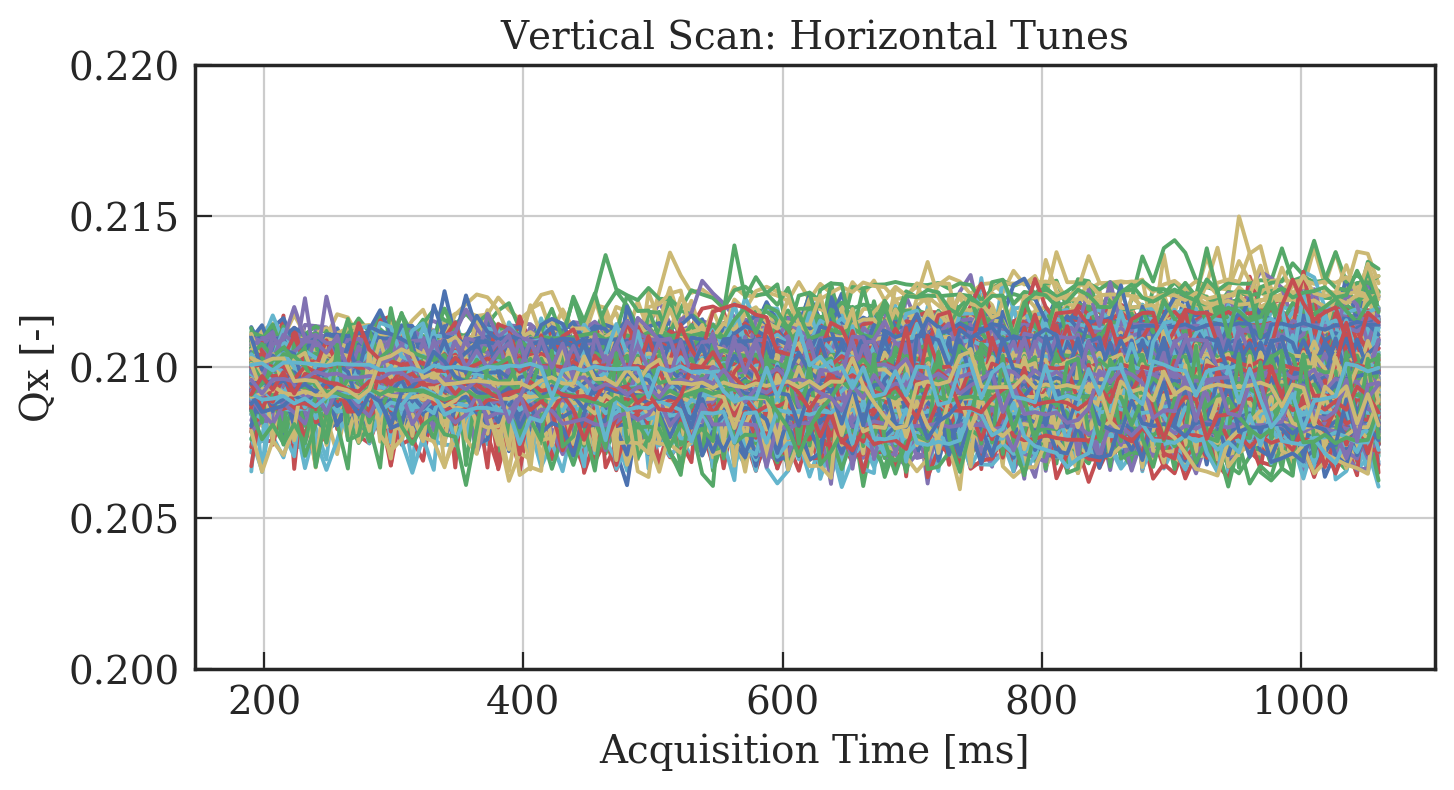

In [8]:
# Plot all Horizontal tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_tune_meas.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.ylabel('Qx [-]')
plt.legend()
plt.title('Vertical Scan: Horizontal Tunes')
plt.grid()
plt.ylim(0.2, 0.22)
fig.savefig('MD4224_Vertical_QX.png')

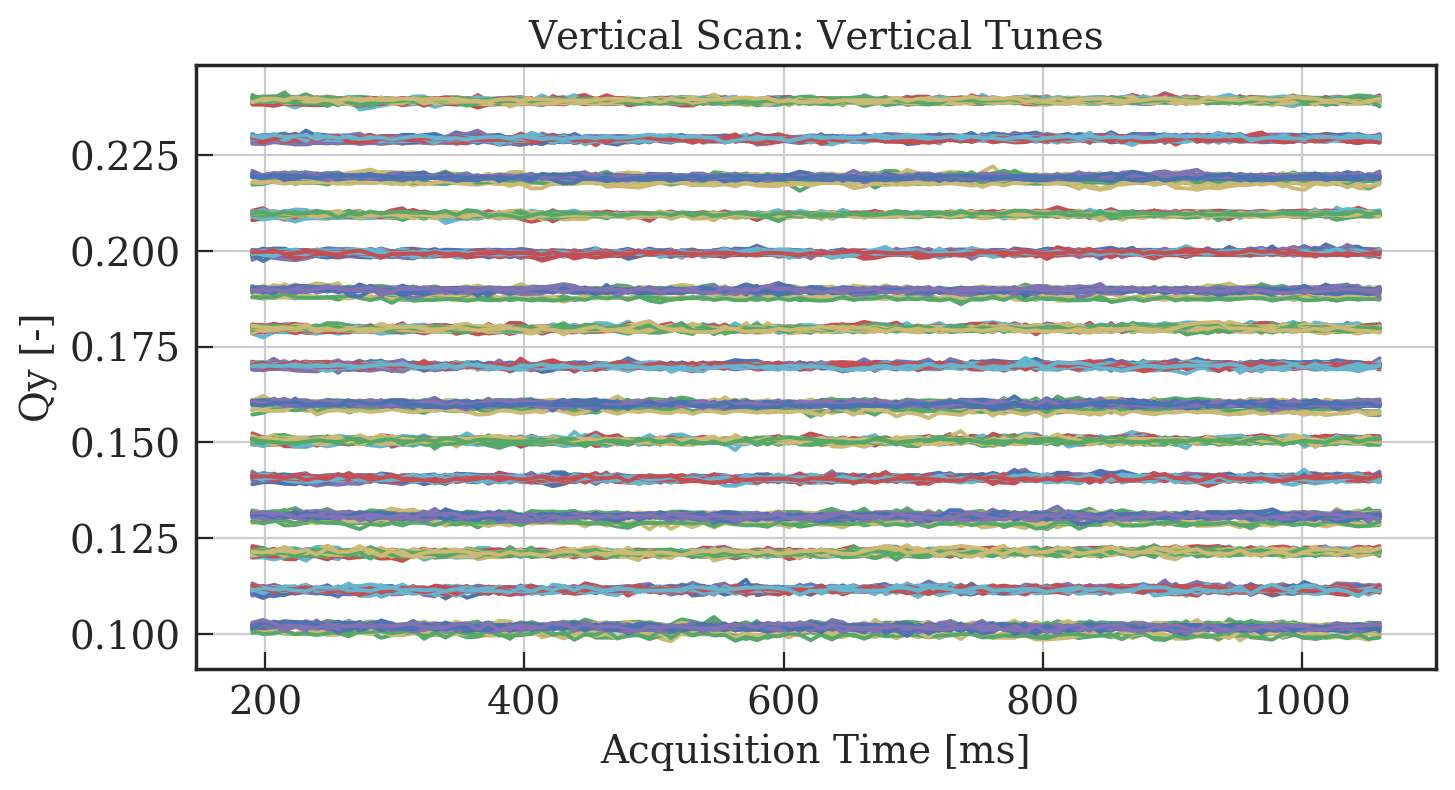

In [9]:
# Plot all Vertical tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_tune_meas.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.ylabel('Qy [-]')
plt.legend()
plt.title('Vertical Scan: Vertical Tunes')
plt.grid()
fig.savefig('MD4224_Vertical_QY.png')

In [10]:
df_tune_meas['Qx']=df_tune_meas.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH'][20:280]),axis=1)
df_tune_meas['Qy']=df_tune_meas.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV'][20:280]),axis=1)

In [11]:
df_intensity=fromMatlabToDataFrame(myFiles,['PR_BCT_ST.Samples.value.samples','PR_BCT_ST.Samples.cycleStamp'])
#print df_intensity

In [12]:
df_intensity['PR_BCT_ST.Samples.cycleStamp']=df_intensity['PR_BCT_ST.Samples.cycleStamp']/1e9
df_intensity['PR_BCT_ST.Samples.cycleStamp']=df_intensity['PR_BCT_ST.Samples.cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_intensity=df_intensity.set_index(['PR_BCT_ST.Samples.cycleStamp'])

In [13]:
df=pnd.merge(df_tune_meas, df_intensity, left_index=True, right_index=True, how='outer')

In [14]:
df_intensity=intensity_df(df,start=70,end=1185)

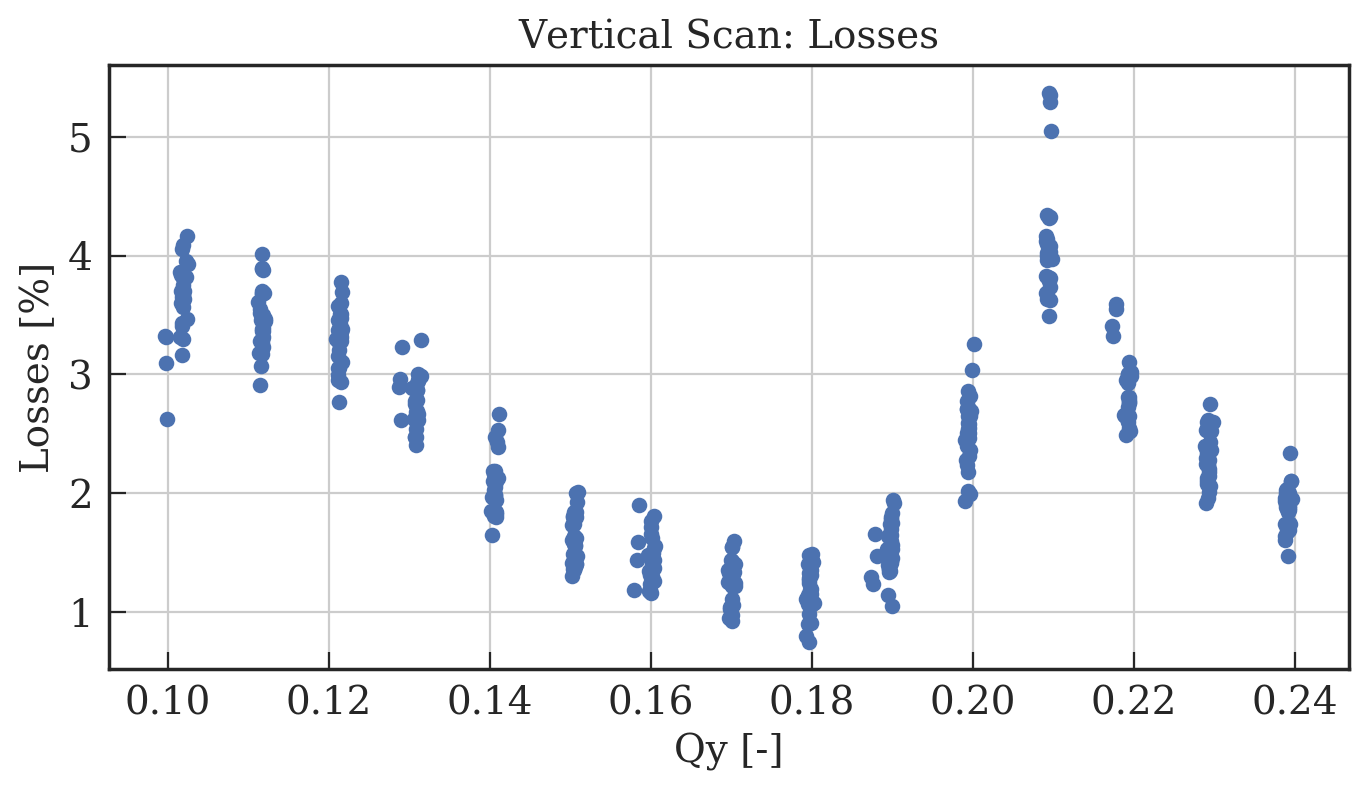

In [15]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_intensity['Qy'],df_intensity['losses'],'o')
plt.xlabel('Qy [-]')
plt.ylabel('Losses [%]')
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_Vertical_Losses_Qy.png')

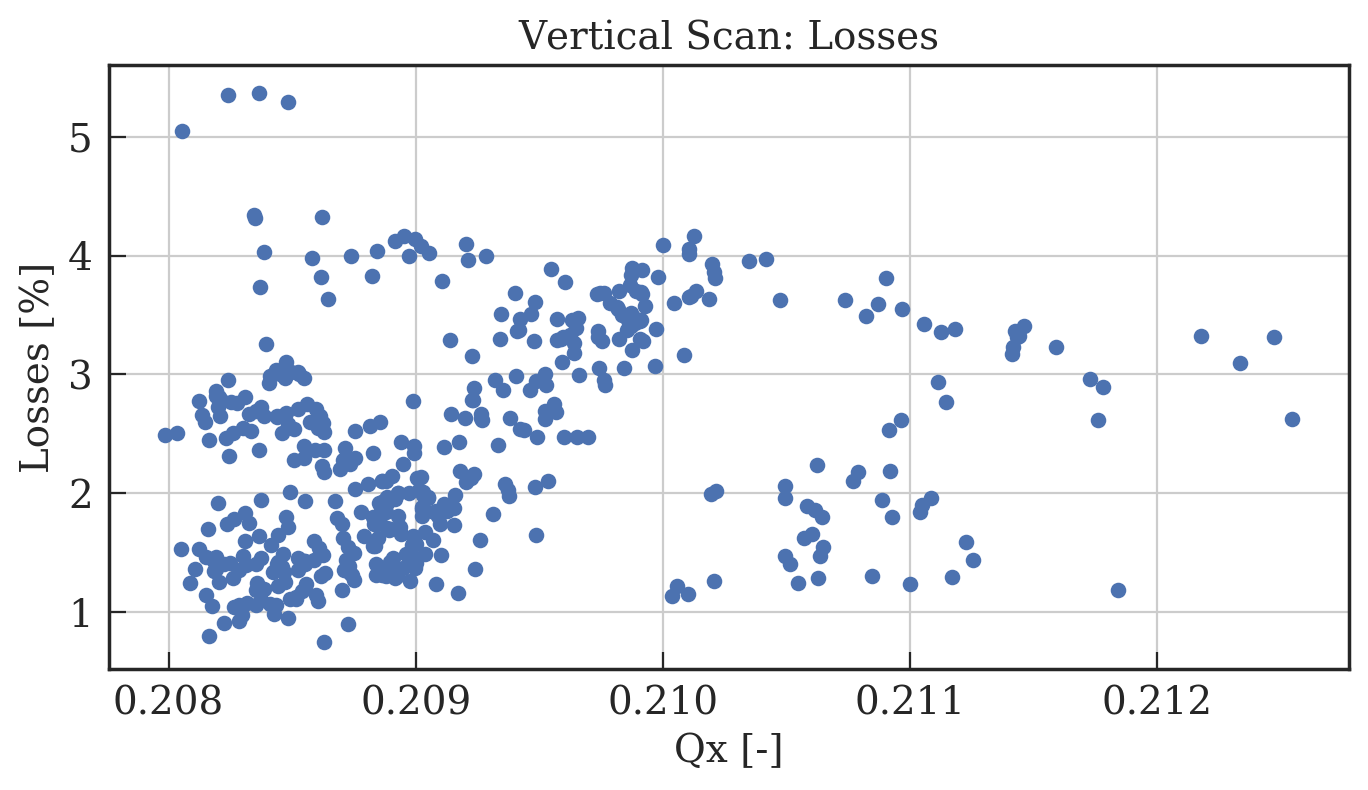

In [16]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_intensity['Qx'],df_intensity['losses'],'o')
plt.xlabel('Qx [-]')
plt.ylabel('Losses [%]')
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_Vertical_Losses_Qx.png')

In [17]:
dfV=read_data(year=2018,date=5,month=9,hour=10,minutes=0,span=5,user='CPS%MD1',WS='64.V')
dfV=profiles(dfV,WS='64.V')
dfV

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,PR.BWS.64.V_ROT:ACQ_DELAY,PR.BWS.64.V_ROT:PROF_POSITION_IN,PR.BCT.LT:SAMPLES,PR.BWS.64.V_ROT:PROF_DATA_IN,cycleStamp,profile V,position V,sig V,mu V,c V,A V
2018-09-05 10:12:06.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.14046, -0.13017, -0.11988, -0.1005, -0.082...","[0.173502430704, 0.172295458822, 0.17209511473...",1.536142e+18,"[-0.00311336961475, -0.00320300503336, -0.0033...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.804676,1.410748,0.176646,6.408463
2018-09-05 10:12:42.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.20706, -0.18889, -0.17557, -0.15317, -0.12...","[0.173099170197, 0.172295458822, 0.17370441311...",1.536142e+18,"[-0.00135413764608, -0.00139215168644, -0.0014...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.881443,1.217762,0.174735,6.724206
2018-09-05 10:13:18.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21311, -0.20282, -0.18889, -0.1671, -0.150...","[0.174514696879, 0.174109083627, 0.17410908362...",1.536142e+18,"[0.000471944769481, 0.000437137188067, 0.00041...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.951880,1.170722,0.173738,6.826287
2018-09-05 10:13:54.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.13985, -0.12956, -0.13198, -0.11685, -0.10...","[0.173300683155, 0.173704413116, 0.17390663066...",1.536142e+18,"[-0.000530929497539, -0.000592998622178, -0.00...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.049412,1.100252,0.173818,6.953522
2018-09-05 10:14:30.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.14591, -0.12472, -0.11624, -0.10111, -0.08...","[0.175124889201, 0.174514696879, 0.17431177227...",1.536142e+18,"[-0.00144977716169, -0.00144252107242, -0.0014...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.921839,1.108730,0.174335,5.005553
2018-09-05 10:15:06.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.20464, -0.18526, -0.16831, -0.14349, -0.12...","[0.175124889201, 0.174514696879, 0.17471785771...",1.536143e+18,"[-0.0016089490748, -0.00167739999193, -0.00168...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.954123,1.120345,0.174833,4.968300
2018-09-05 10:15:42.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.22098, -0.21008, -0.20161, -0.18223, -0.15...","[0.173300683155, 0.173099170197, 0.17350243070...",1.536143e+18,"[-0.000607511327891, -0.000590121244244, -0.00...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.006642,0.895424,0.173420,4.955150
2018-09-05 10:16:18.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.1562, -0.15136, -0.14409, -0.13441, -0.120...","[0.173300683155, 0.172496036142, 0.17309917019...",1.536143e+18,"[-0.00191253690073, -0.00193234317971, -0.0019...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.950884,1.158238,0.173525,5.174617
2018-09-05 10:16:54.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.11806, -0.1114, -0.10413, -0.09142, -0.076...","[0.173704413116, 0.174109083627, 0.17330068315...",1.536143e+18,"[-0.000993234178027, -0.00104358929646, -0.001...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.864489,1.232745,0.172981,5.056498
2018-09-05 10:17:30.700,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.18284, -0.16347, -0.15075, -0.1338, -0.113...","[0.172696846963, 0.172897891557, 0.17390663066...",1.536143e+18,"[-0.00395227032195, -0.00400073642059, -0.0040...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.868754,1.085918,0.174423,4.778569


In [18]:
# Test Gaussian fit function
#makeGaussianFit_5_parameters(dfV['PR.BWS.64.V_ROT:PROF_POSITION_IN'].iloc[0]/1000,dfV['PR.BWS.64.V_ROT:PROF_DATA_IN'].iloc[0],for_df=False,window=50)

2018-09-05 10:12:06.700      [Line2D(_line0)]
2018-09-05 10:12:42.700      [Line2D(_line1)]
2018-09-05 10:13:18.700      [Line2D(_line2)]
2018-09-05 10:13:54.700      [Line2D(_line3)]
2018-09-05 10:14:30.700      [Line2D(_line4)]
2018-09-05 10:15:06.700      [Line2D(_line5)]
2018-09-05 10:15:42.700      [Line2D(_line6)]
2018-09-05 10:16:18.700      [Line2D(_line7)]
2018-09-05 10:16:54.700      [Line2D(_line8)]
2018-09-05 10:17:30.700      [Line2D(_line9)]
2018-09-05 10:18:06.700     [Line2D(_line10)]
2018-09-05 10:19:18.700     [Line2D(_line11)]
2018-09-05 10:20:30.700     [Line2D(_line12)]
2018-09-05 10:21:06.700     [Line2D(_line13)]
2018-09-05 10:21:42.700     [Line2D(_line14)]
2018-09-05 10:22:18.700     [Line2D(_line15)]
2018-09-05 10:22:54.700     [Line2D(_line16)]
2018-09-05 10:23:30.700     [Line2D(_line17)]
2018-09-05 10:24:06.700     [Line2D(_line18)]
2018-09-05 10:24:42.700     [Line2D(_line19)]
2018-09-05 10:25:18.700     [Line2D(_line20)]
2018-09-05 10:25:54.700     [Line2

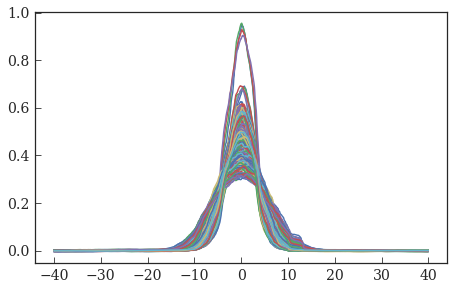

In [19]:
# Plot position vs profile
dfV.apply(lambda x: plt.plot( x['position V'],x['profile V']) , axis=1)

2018-09-05 10:12:06.700      [Line2D(_line0)]
2018-09-05 10:12:42.700      [Line2D(_line1)]
2018-09-05 10:13:18.700      [Line2D(_line2)]
2018-09-05 10:13:54.700      [Line2D(_line3)]
2018-09-05 10:14:30.700      [Line2D(_line4)]
2018-09-05 10:15:06.700      [Line2D(_line5)]
2018-09-05 10:15:42.700      [Line2D(_line6)]
2018-09-05 10:16:18.700      [Line2D(_line7)]
2018-09-05 10:16:54.700      [Line2D(_line8)]
2018-09-05 10:17:30.700      [Line2D(_line9)]
2018-09-05 10:18:06.700     [Line2D(_line10)]
2018-09-05 10:19:18.700     [Line2D(_line11)]
2018-09-05 10:20:30.700     [Line2D(_line12)]
2018-09-05 10:21:06.700     [Line2D(_line13)]
2018-09-05 10:21:42.700     [Line2D(_line14)]
2018-09-05 10:22:18.700     [Line2D(_line15)]
2018-09-05 10:22:54.700     [Line2D(_line16)]
2018-09-05 10:23:30.700     [Line2D(_line17)]
2018-09-05 10:24:06.700     [Line2D(_line18)]
2018-09-05 10:24:42.700     [Line2D(_line19)]
2018-09-05 10:25:18.700     [Line2D(_line20)]
2018-09-05 10:25:54.700     [Line2

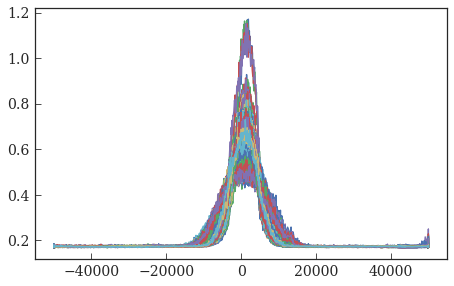

In [20]:
dfV.apply(lambda x: plt.plot( x['PR.BWS.64.V_ROT:PROF_POSITION_IN'],x['PR.BWS.64.V_ROT:PROF_DATA_IN']) ,axis=1)

In [21]:
df=pnd.merge(df_tune_meas,dfV,left_index=True, right_index=True, how='outer')
print df

                            cycleStamp_x     matlabPLS  \
2018-09-05 10:12:06.700000           NaN           NaN   
2018-09-05 10:12:42.700000           NaN           NaN   
2018-09-05 10:13:18.700000           NaN           NaN   
2018-09-05 10:13:54.700000           NaN           NaN   
2018-09-05 10:14:30.700000           NaN           NaN   
2018-09-05 10:15:06.700000           NaN           NaN   
2018-09-05 10:15:42.700000           NaN           NaN   
2018-09-05 10:16:18.700000           NaN           NaN   
2018-09-05 10:16:54.700000           NaN           NaN   
2018-09-05 10:17:30.700000           NaN           NaN   
2018-09-05 10:18:06.700000           NaN           NaN   
2018-09-05 10:19:18.700000           NaN           NaN   
2018-09-05 10:19:39.260858  1.536143e+18  CPS.USER.MD1   
2018-09-05 10:19:54.700000  1.536143e+18  CPS.USER.MD1   
2018-09-05 10:20:30.700000  1.536143e+18  CPS.USER.MD1   
2018-09-05 10:21:06.700000  1.536143e+18  CPS.USER.MD1   
2018-09-05 10:

In [22]:
# gives empty df for some reason
# df=df.dropna(axis=0,how='all',subset =['profile V'])
# print df

In [23]:
df=df.dropna(axis=0,how='all',subset =['Qy'])
df=df.dropna(axis=0,how='all',subset =['sig V'])

In [24]:
df=df.dropna(axis=1,how='all')
#df

In [25]:
dfV=df
dfV

,cycleStamp_x,matlabPLS,matlabFilePath,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy,PR.BWS.64.V_ROT:ACQ_DELAY,PR.BWS.64.V_ROT:PROF_POSITION_IN,PR.BCT.LT:SAMPLES,PR.BWS.64.V_ROT:PROF_DATA_IN,cycleStamp_y,profile V,position V,sig V,mu V,c V,A V
2018-09-05 10:20:30.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.239792971091, 0.239276007764, 0.23983197440...","[0.209100969861, 0.209194476016, 0.20912711722...",0.208899,0.239078,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21493, -0.2004, -0.18587, -0.16347, -0.138...","[0.172295458822, 0.172295458822, 0.17350243070...",1.536143e+18,"[-0.00233579299797, -0.00231364141022, -0.0023...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.020507,1.195308,0.174343,4.664108
2018-09-05 10:21:06.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.229844272763, 0.230008764515, 0.22985481375...","[0.209000257804, 0.208807813289, 0.20901451777...",0.208694,0.229331,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.19495, -0.18526, -0.17436, -0.15317, -0.13...","[0.173906630666, 0.173300683155, 0.17289789155...",1.536143e+18,"[-0.00208965889083, -0.00208855425608, -0.0020...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.127899,1.060240,0.173155,4.737049
2018-09-05 10:21:42.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.219602337991, 0.219743499994, 0.22020850263...","[0.209204467302, 0.20915974993, 0.208612183948...",0.208412,0.219715,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.14228, -0.13138, -0.12775, -0.11019, -0.09...","[0.173906630666, 0.173704413116, 0.17471785771...",1.536143e+18,"[-0.000654113628849, -0.000612977576164, -0.00...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",2.900716,1.141848,0.173898,4.204296
2018-09-05 10:22:18.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.210281556769, 0.209422273069, 0.20961770354...","[0.207159741448, 0.209990316606, 0.21018549122...",0.208581,0.209510,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.13864, -0.12593, -0.11503, -0.09505, -0.07...","[0.172095114733, 0.171296065257, 0.17109688325...",1.536143e+18,"[-0.000407566983652, -0.000342627570871, -0.00...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.264278,1.089502,0.173774,4.446328
2018-09-05 10:22:54.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.198713668256, 0.198966392655, 0.20010259522...","[0.210092149554, 0.209859522971, 0.20899092989...",0.208356,0.199719,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.19676, -0.18345, -0.17013, -0.14288, -0.12...","[0.173906630666, 0.173099170197, 0.17330068315...",1.536143e+18,"[-0.000692627692312, -0.000660000229826, -0.00...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.203393,0.919885,0.173308,4.440490
2018-09-05 10:23:30.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.18996206375, 0.190606973165, 0.189938681955...","[0.209334719865, 0.208732507955, 0.20916493789...",0.208183,0.189839,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21372, -0.2004, -0.18889, -0.17557, -0.155...","[0.173906630666, 0.174311772274, 0.17350243070...",1.536143e+18,"[-0.00091143420421, -0.000812660672319, -0.000...","[-40.0, -39.9199199199, -39.8398398398, -39.75...",3.320072,0.968817,0.173377,4.561934
2018-09-05 10:24:06.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.180020225235, 0.179885403048, 0.18069884960...","[0.209168094096, 0.209135162217, 0.20884570737...",0.208225,0.179881,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.16226, -0.15499, -0.1447, -0.13259, -0.119...","[0.174109083627, 0.173502430704, 0.17451469687...",1.536143e+18,"[-0.00128764230464, -0.00120138512325, -0.0010...","[-40.0, -39.9199199199, -3

In [26]:
def second_moment_2(values, weights, sig, n_sigmas=6.):
    a=np.where((values<n_sigmas*sig) & (values>-n_sigmas*sig))[0]
    values=values[a]
    weights=weights[a]    
    weighted_average = np.average(values, weights=weights)
    second_moment = np.sqrt(np.average((values-weighted_average)**2, weights=weights))
    return (second_moment)

In [27]:
dfV['second_moment V']=dfV.apply(lambda x: second_moment_2(x['position V'], x['profile V'], x['sig V'], n_sigmas=6.), axis=1)

In [28]:
# Set beta functions
#dfV['bety']=np.nan
#dfV['bety'][(dfV['Qy']==0.3)&(dfV['Qx']==0.3)]=13.

In [29]:
def emittance_df(ndf,WS='64.V',myFiles=None,beta=0.91444281513833,gamma=2.4708737618826,dp=1e-3):
    df=ndf.copy()
    a=df.columns
    if 'emittance V' not in a:
        df['emittance V']=np.nan
    if 'emittance H' not in a:
        df['emittance H']=np.nan
    if 'sig V' not in a:
        df=profiles(df,WS=WS)
    if 'sig H' not in a:
        df=profiles(df,WS=WS)
    span=span_range(df,myFiles=myFiles)
    if WS[-1]=='V':
        if 'bety' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance V']=beta*gamma*(df['sig V'].iloc[i]**2)/df['bety'].iloc[i]
    else:
        if 'betx' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance H']=beta*gamma*(df['sig H'].iloc[i]**2-(df['dx'].iloc[i]*1000)**2*dp**2)/df['betx'].iloc[i]
    return df


In [30]:
dfV=emittance_df(dfV,WS='64.V')

In [31]:
dfV

,cycleStamp_x,matlabPLS,matlabFilePath,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy,PR.BWS.64.V_ROT:ACQ_DELAY,PR.BWS.64.V_ROT:PROF_POSITION_IN,PR.BCT.LT:SAMPLES,...,sig V,mu V,c V,A V,second_moment V,emittance V,emittance H,betx,bety,dx
2018-09-05 10:20:30.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.239792971091, 0.239276007764, 0.23983197440...","[0.209100969861, 0.209194476016, 0.20912711722...",0.208899,0.239078,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21493, -0.2004, -0.18587, -0.16347, -0.138...",...,3.020507,1.195308,0.174343,4.664108,3.249349,0.921398,NaN,12.321829,22.372767,2.407925
2018-09-05 10:21:06.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.229844272763, 0.230008764515, 0.22985481375...","[0.209000257804, 0.208807813289, 0.20901451777...",0.208694,0.229331,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.19495, -0.18526, -0.17436, -0.15317, -0.13...",...,3.127899,1.060240,0.173155,4.737049,3.271565,0.985468,NaN,12.258407,22.432094,2.433172
2018-09-05 10:21:42.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.219602337991, 0.219743499994, 0.22020850263...","[0.209204467302, 0.20915974993, 0.208612183948...",0.208412,0.219715,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.14228, -0.13138, -0.12775, -0.11019, -0.09...",...,2.900716,1.141848,0.173898,4.204296,3.013705,0.845260,NaN,12.190063,22.491974,2.459363
2018-09-05 10:22:18.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.210281556769, 0.209422273069, 0.20961770354...","[0.207159741448, 0.209990316606, 0.21018549122...",0.208581,0.209510,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.13864, -0.12593, -0.11503, -0.09505, -0.07...",...,3.264278,1.089502,0.173774,4.446328,3.212568,1.067550,NaN,12.116163,22.552411,2.486634
2018-09-05 10:22:54.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.198713668256, 0.198966392655, 0.20010259522...","[0.210092149554, 0.209859522971, 0.20899092989...",0.208356,0.199719,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.19676, -0.18345, -0.17013, -0.14288, -0.12...",...,3.203393,0.919885,0.173308,4.440490,3.328876,1.025325,NaN,12.035960,22.613412,2.515138
2018-09-05 10:23:30.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.18996206375, 0.190606973165, 0.189938681955...","[0.209334719865, 0.208732507955, 0.20916493789...",0.208183,0.189839,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21372, -0.2004, -0.18889, -0.17557, -0.155...",...,3.320072,0.968817,0.173377,4.561934,3.458799,1.098387,NaN,11.948573,22.674979,2.545055
2018-09-05 10:24:06.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.180020225235, 0.179885403048, 0.18069884960...","[0.209168094096, 0.209135162217, 0.20884570737...",0.208225,0.179881,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.16226, -0.15499, -0.1447, -0.13259, -0.119...",...,3.340414,1.069337,0.173095,4.514304,3.464745,1.108849,NaN,11.852945,22.737115,2.576596
2018-09-05 10:24:42.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.17112674477, 0.170014074023, 0.171017087404...","[0.20855192735, 0.209574260259, 0.208917102576...",0.208439,0.170431,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.12714, -0.11564, -0.10716, -0.089, -0.0684...",...,3.511170,1.167666,0.173159,4.489375,3.456128,1.221741,NaN,11.747798,22.799820,2.610009
2018-09-05 10:25:18.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.160967104414, 0.162119228207, 0.16076827093...","[0.209348021254, 0.208038494882, 0.20935993151...",0.208975,0.160332,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.18526, -0.16468, -0.15075, -0.13319

Text(0,0.5,u'Emittance y [mm mrad]')

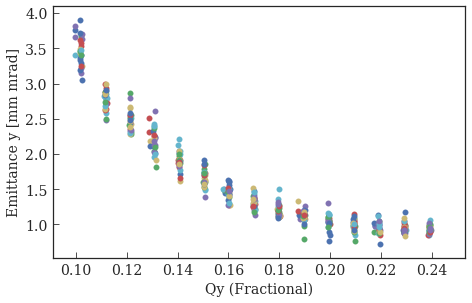

In [32]:
dfV.apply(lambda x: plt.scatter( x['Qy'], x['emittance V']) ,axis=1)
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance y [mm mrad]')

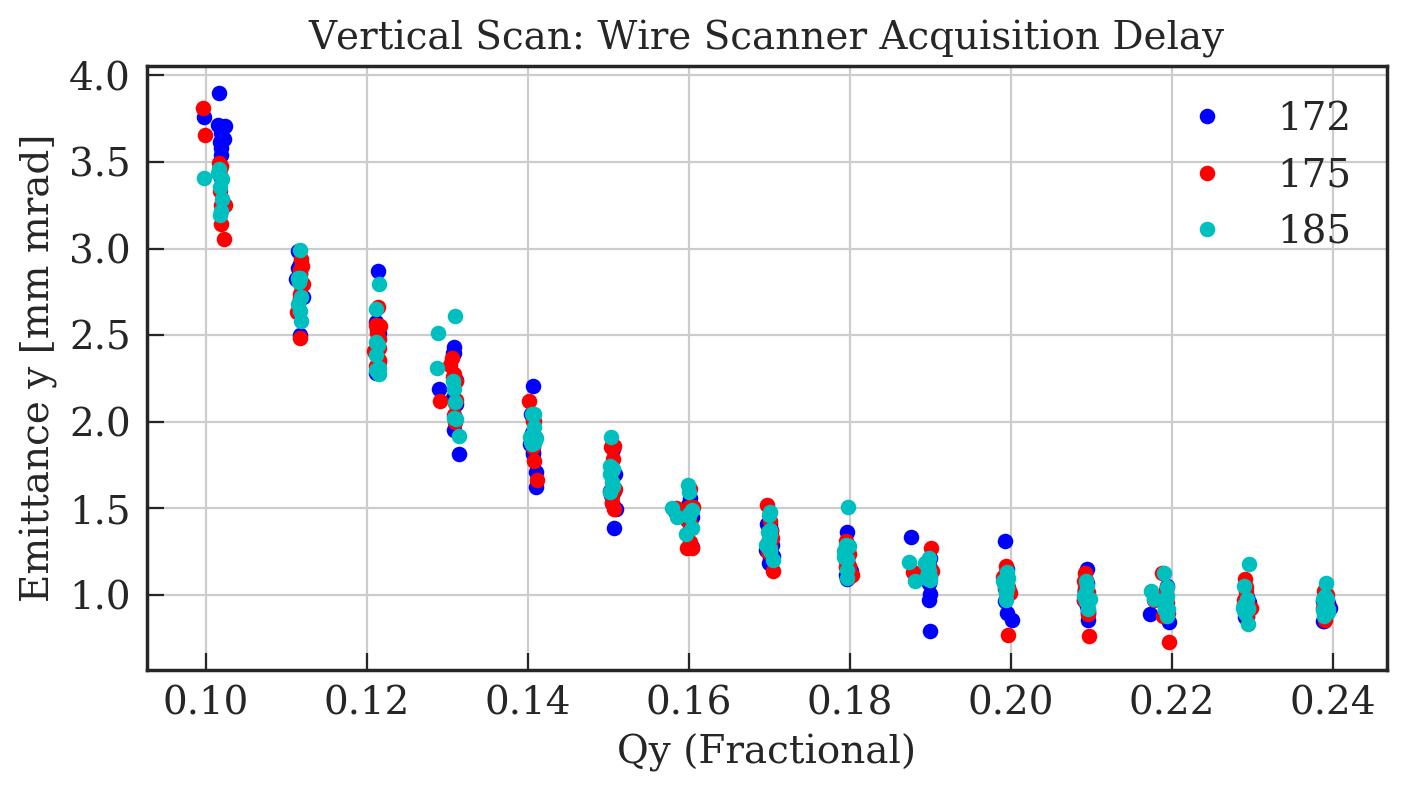

In [33]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==172)], dfV['emittance V'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==175)], dfV['emittance V'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==185)], dfV['emittance V'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance y [mm mrad]')
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')
plt.grid()
fig.savefig('MD4224_Vertical_WS_Delay_Emittance.png')

Text(0.5,1,u'Vertical Scan: Wire Scanner Acquisition Delay')

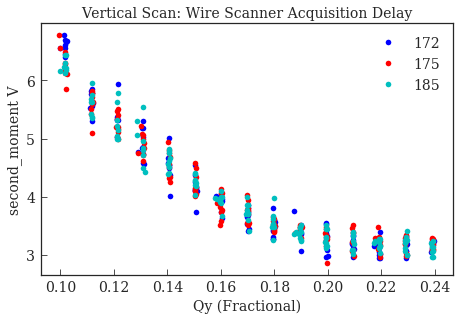

In [34]:
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==172)], dfV['second_moment V'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==175)], dfV['second_moment V'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==185)], dfV['second_moment V'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('second_moment V')
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')

(0.2, 0.22)

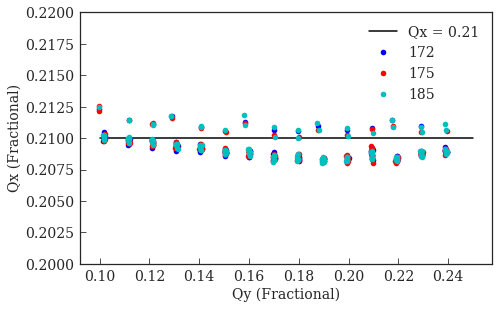

In [35]:

plt.plot([0.1, .25], [.21, .21], 'k-', lw=1.5, label='Qx = 0.21')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==172)], dfV['Qx'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==175)], dfV['Qx'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(dfV['Qy'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==185)], dfV['Qx'][(dfV['PR.BWS.64.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Qx (Fractional)')
plt.legend()
plt.ylim(0.2, 0.22)

In [39]:
df_new=pnd.merge(dfV, df_intensity, left_index=True, right_index=True, how='outer')
df_new=df_new.dropna(axis=0,how='all',subset =['Qy'])
df_new=df_new.dropna(axis=0,how='all',subset =['sig V'])
df_new

,cycleStamp_x_x,matlabPLS,matlabFilePath,PR_BQS72.SamplerAcquisition.value.estimatedTuneV_x,PR_BQS72.SamplerAcquisition.value.estimatedTuneH_x,Qx_x,Qy_x,PR.BWS.64.V_ROT:ACQ_DELAY,PR.BWS.64.V_ROT:PROF_POSITION_IN,PR.BCT.LT:SAMPLES,...,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy,cycleStamp_y,matlabPLS_y_y,matlabFilePath_y_y,PR_BCT_ST.Samples.value.samples_y,losses_y,ratio_y
2018-09-05 10:20:30.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.239792971091, 0.239276007764, 0.23983197440...","[0.209100969861, 0.209194476016, 0.20912711722...",0.208899,0.239078,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21493, -0.2004, -0.18587, -0.16347, -0.138...",...,"[0.239792971091, 0.239276007764, 0.23983197440...","[0.209100969861, 0.209194476016, 0.20912711722...",0.208899,0.239078,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[-0.21493, -0.2004, -0.18587, -0.16347, -0.138...",1.698342,0.983017
2018-09-05 10:21:06.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.229844272763, 0.230008764515, 0.22985481375...","[0.209000257804, 0.208807813289, 0.20901451777...",0.208694,0.229331,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.19495, -0.18526, -0.17436, -0.15317, -0.13...",...,"[0.229844272763, 0.230008764515, 0.22985481375...","[0.209000257804, 0.208807813289, 0.20901451777...",0.208694,0.229331,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[-0.19495, -0.18526, -0.17436, -0.15317, -0.13...",2.203742,0.977963
2018-09-05 10:21:42.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.219602337991, 0.219743499994, 0.22020850263...","[0.209204467302, 0.20915974993, 0.208612183948...",0.208412,0.219715,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.14228, -0.13138, -0.12775, -0.11019, -0.09...",...,"[0.219602337991, 0.219743499994, 0.22020850263...","[0.209204467302, 0.20915974993, 0.208612183948...",0.208412,0.219715,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[-0.14228, -0.13138, -0.12775, -0.11019, -0.09...",2.985061,0.970149
2018-09-05 10:22:18.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.210281556769, 0.209422273069, 0.20961770354...","[0.207159741448, 0.209990316606, 0.21018549122...",0.208581,0.209510,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.13864, -0.12593, -0.11503, -0.09505, -0.07...",...,"[0.210281556769, 0.209422273069, 0.20961770354...","[0.207159741448, 0.209990316606, 0.21018549122...",0.208581,0.209510,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[-0.13864, -0.12593, -0.11503, -0.09505, -0.07...",3.982576,0.960174
2018-09-05 10:22:54.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.198713668256, 0.198966392655, 0.20010259522...","[0.210092149554, 0.209859522971, 0.20899092989...",0.208356,0.199719,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.19676, -0.18345, -0.17013, -0.14288, -0.12...",...,"[0.198713668256, 0.198966392655, 0.20010259522...","[0.210092149554, 0.209859522971, 0.20899092989...",0.208356,0.199719,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[-0.19676, -0.18345, -0.17013, -0.14288, -0.12...",2.690493,0.973095
2018-09-05 10:23:30.700,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[0.18996206375, 0.190606973165, 0.189938681955...","[0.209334719865, 0.208732507955, 0.20916493789...",0.208183,0.189839,172.0,"[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...","[-0.21372, -0.2004, -0.18889, -0.17557, -0.155...",...,"[0.18996206375, 0.190606973165, 0.189938681955...","[0.209334719865, 0.208732507955, 0.20916493789...",0.208183,0.189839,1.536143e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.05_vertica...,"[-0.21372,

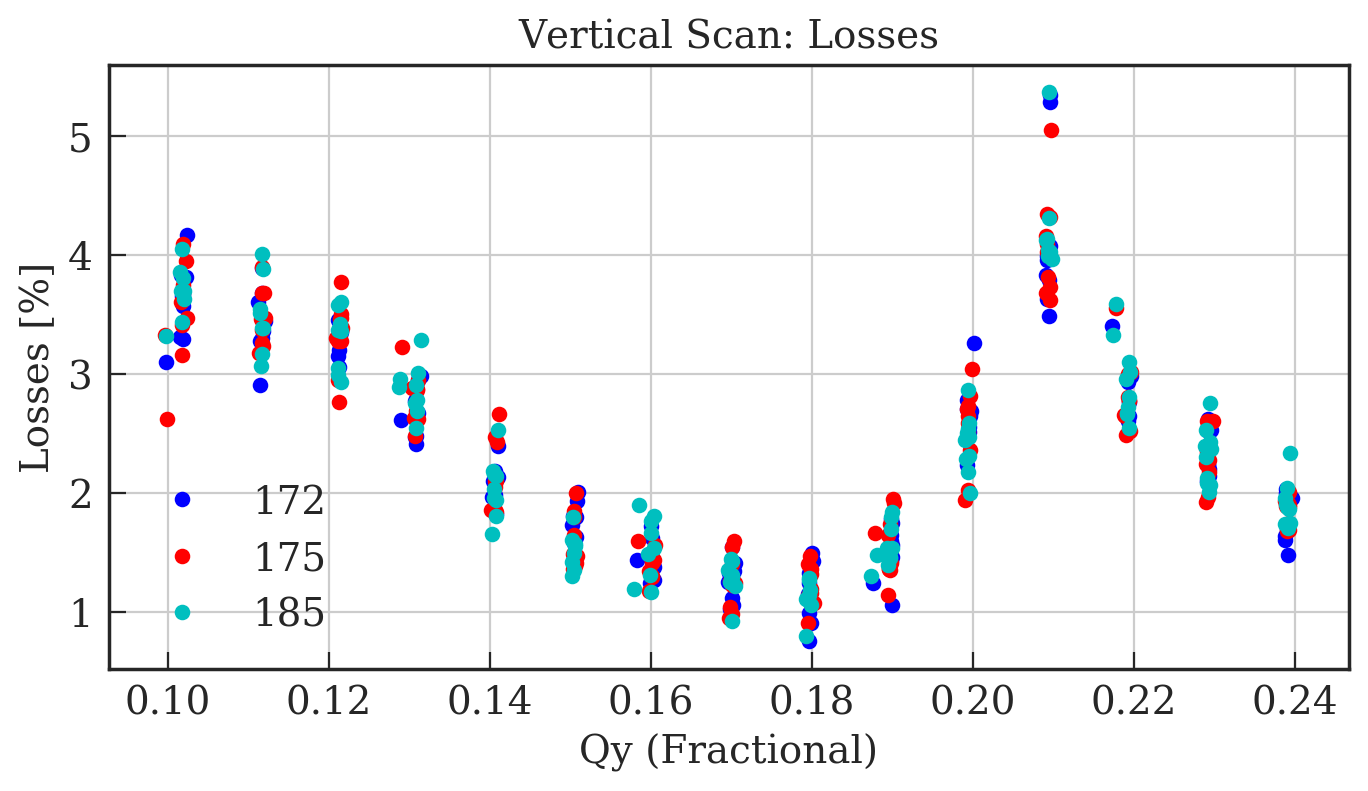

In [42]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_new['Qy'][(df_new['PR.BWS.64.V_ROT:ACQ_DELAY']==172)], df_new['losses_y'][(df_new['PR.BWS.64.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_new['Qy'][(df_new['PR.BWS.64.V_ROT:ACQ_DELAY']==175)], df_new['losses_y'][(df_new['PR.BWS.64.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_new['Qy'][(df_new['PR.BWS.64.V_ROT:ACQ_DELAY']==185)], df_new['losses_y'][(df_new['PR.BWS.64.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Losses [%]')
plt.legend()
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_Vertical_Losses_vs_WS_Acqusition.png')